# Nick's Modeling

In [1]:
import os
import pathlib
working_dir = pathlib.Path().absolute()
os.chdir(working_dir)

In [2]:
import pandas as pd
import numpy as np
import datetime

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.integrate import odeint

from matplotlib import pyplot
import matplotlib.pylab as plt 
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

rs = 109

In [3]:
country_names = ['United States']

state_names = ["Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", "Colorado", 
               "Connecticut", "District ", "of Columbia", "Delaware", "Florida", "Georgia", "Guam", 
               "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", 
               "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi",
               "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey",
               "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", 
               "Puerto Rico", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas",
               "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", "Wisconsin", 
               "West Virginia", "Wyoming"]

city_names = ['Ann Arbor', 'Annapolis', 'Atlanta', 'Austin', 'Bakersfield', 'Baltimore', 'Birmingham - Alabama',
             'Boston', 'Bridgeport', 'Charlotte', 'Cincinnati', 'Cleveland', 'Colorado Spring', 'Columbus',
             'Corpus Christi', 'Dallas', 'Denver', 'Detroit', 'Fresno', 'Grand Rapids', 'Greensboro',
             'Hartford', 'Honolulu', 'Houston', 'Indianapolis', 'Jacksonville', 'Kansas City', 'Las Vegas',
             'Lexington', 'Los Angeles', 'Louisville', 'Madison', 'Memphis', 'Miami', 'Milwaukee', 
             'Minneapolis', 'Modesto', 'Monterey', 'Nashville', 'New Haven', 'New Orleans', 'New York City',
             'Oklahoma City', 'Omaha', 'Orlando', 'Philadelphia', 'Phoenix', 'Pittsburgh', 'Portland', 'Providence',
             'Raleigh', 'Richmond', 'Rochester', 'Sacramento', 'Saint Petersburg - Clearwater (Florida)', 'Salt Lake City',
             'San Antonio', 'San Diego', 'San Francisco - Bay Area', 'Santa Barbara', 'Seattle', 'Spokane', 'St. Louis',
             'Tacoma', 'Tampa', 'Tucson', 'Tulsa', 'Ventura', 'Virginia Beach', 'Washington DC']

us_locations = country_names + state_names + city_names
apple_mobility = pd.read_csv('data/applemobilitytrends-2020-05-03.csv') # will need to change this
apple_countries = apple_mobility[apple_mobility['geo_type'] == 'country/region']
apple_us = apple_mobility[apple_mobility['region'].isin(us_locations)]

In [4]:
google_mobility = pd.read_csv('data/Global_Mobility_Report.csv', dtype={'sub_region_1': 'object', 'sub_region_2': 'object'})
google_mobility['date'] = pd.to_datetime(google_mobility['date'])
google_us = google_mobility[google_mobility['country_region_code'] == 'US']

Text(0, 0.5, 'Percentage Mobility')

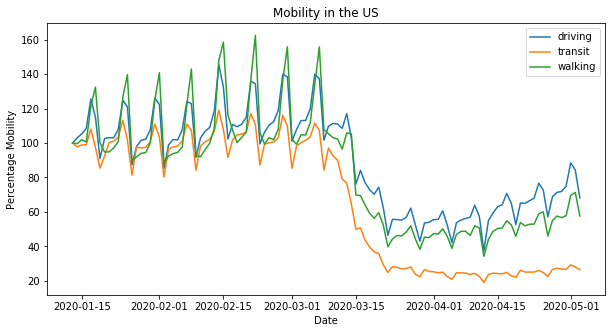

In [5]:
trans_type = ['driving', 'transit', 'walking']
apple_us_total = apple_us[apple_us['region'] == 'United States']
num_days = len(apple_us_total.columns[4:])
base = datetime.datetime(2020, 1, 13)
date_list = [base + datetime.timedelta(days=x) for x in range(num_days)]

plt.figure(0, figsize=(10,5))
for i in range(3):
    y = apple_us_total.values[i][4:]
    plt.plot(date_list, y, label=trans_type[i])
plt.legend()
plt.title('Mobility in the US')
plt.xlabel('Date')
plt.ylabel('Percentage Mobility')

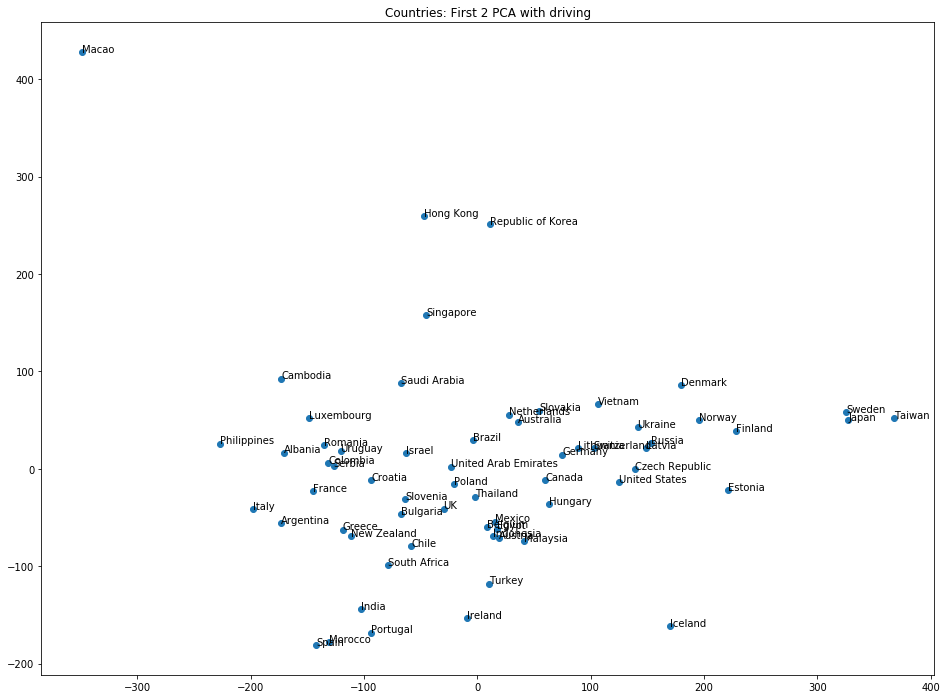

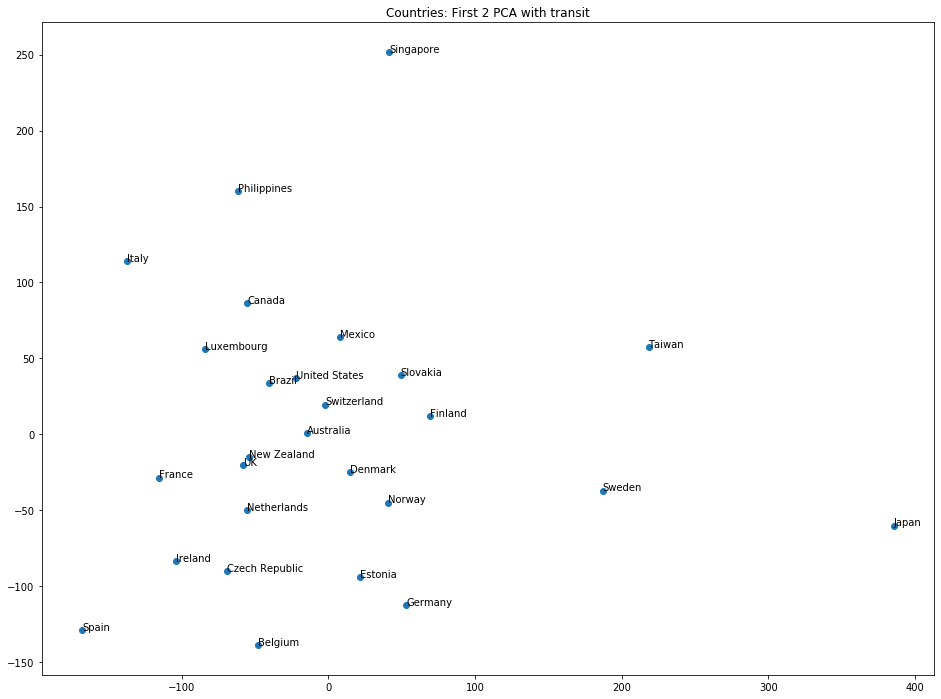

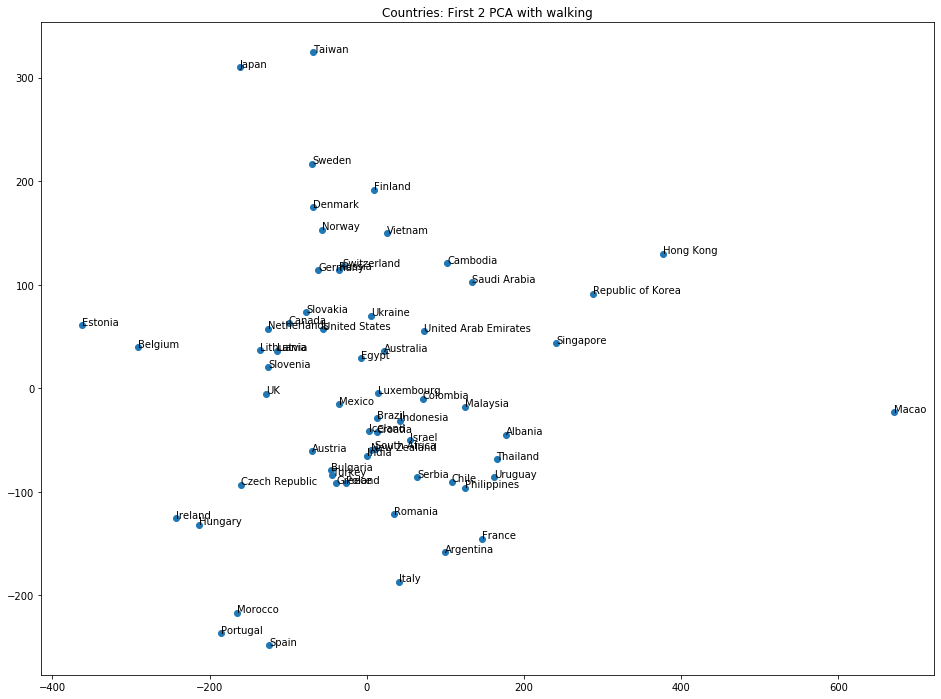

In [6]:
trans_type = ['driving', 'transit', 'walking']
apple_countries_idx = apple_countries.set_index('region').drop(columns=['geo_type', 'alternative_name'])

apple_countries_drive = apple_countries_idx[apple_countries_idx['transportation_type'] == 'driving'].drop(columns='transportation_type')

trans_pcas = []
trans_pcas_countries = []

for t in trans_type:
    pca = PCA(n_components=2)
    apple_countries_type = apple_countries_idx[apple_countries_idx['transportation_type'] == t].drop(columns='transportation_type')
    countries_pca = pca.fit_transform(apple_countries_type)
    trans_pcas.append(countries_pca)
    x = countries_pca.T[0]
    y = countries_pca.T[1]
    fig, ax = plt.subplots(figsize=(16,12))
    ax.scatter(x,y)
    ax.set_title('Countries: First 2 PCA with ' + t)
    trans_pcas_countries.append(apple_countries_type.index)
    for i, txt in enumerate(apple_countries_type.index):
        ax.annotate(txt, (x[i], y[i]))

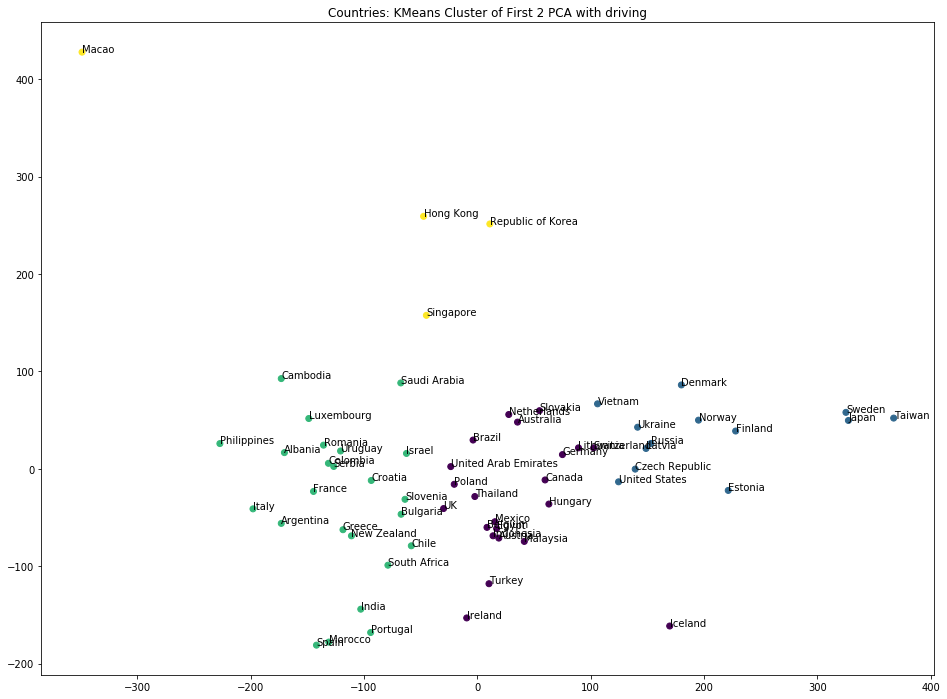

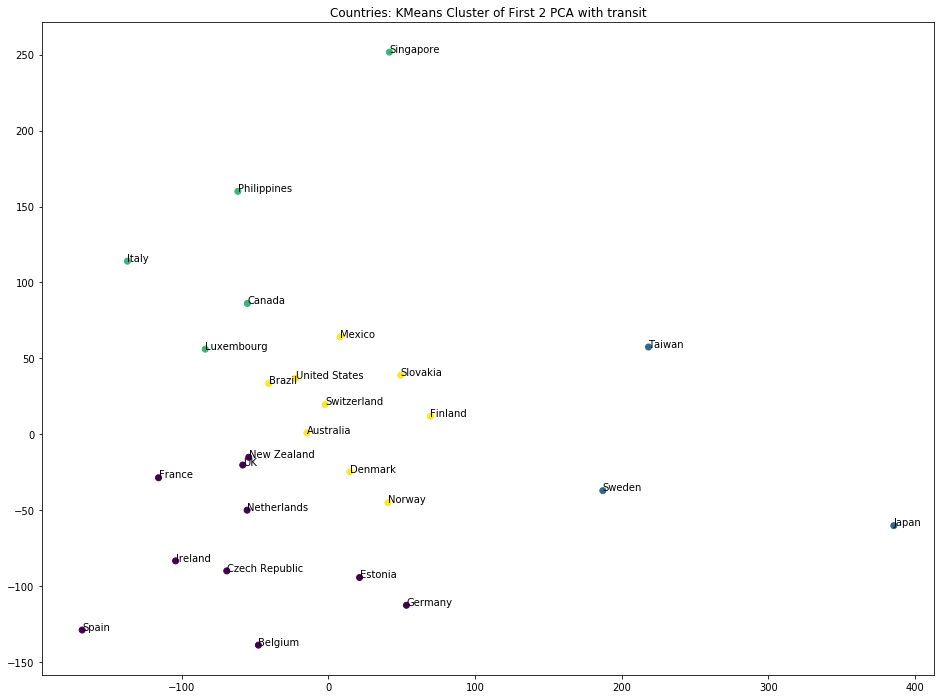

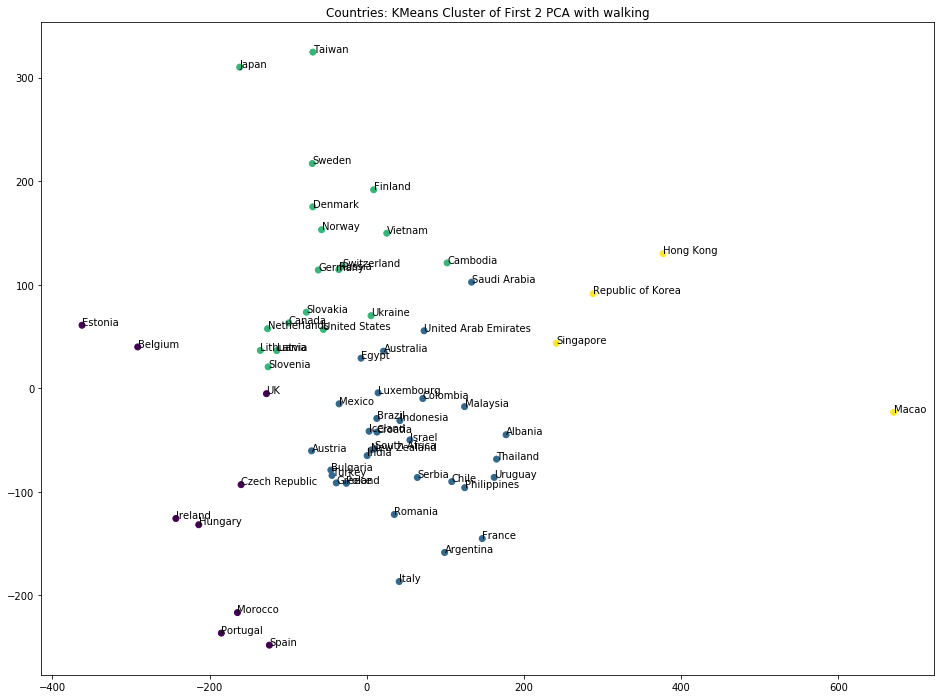

In [7]:
for i in range(3):
    km = KMeans(n_clusters=4, random_state=rs).fit(trans_pcas[i])
    x = trans_pcas[i].T[0]
    y = trans_pcas[i].T[1]
    fig, ax = plt.subplots(figsize=(16,12))
    ax.scatter(x, y, c=km.predict(trans_pcas[i]))
    ax.set_title('Countries: KMeans Cluster of First 2 PCA with ' + str(trans_type[i]))
    for i, txt in enumerate(trans_pcas_countries[i]):
        ax.annotate(txt, (x[i], y[i]))

# SIR Model with Modifications - Apple

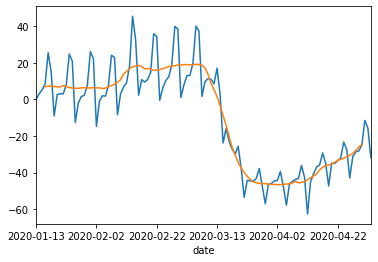

In [8]:
# NECESSARY DATA WRANGLING

data_columns = ['driving', 'transit', 'walking']

apple_us_total = apple_us[apple_us['geo_type'] == 'country/region']
transposed_apple = apple_us_total.drop(columns=['geo_type', 'region', 'alternative_name']).T
transposed_apple = transposed_apple.reset_index().rename(columns={'index': 'date', 146: 'driving', 147: 'transit', 148:'walking'}).iloc[1:]
transposed_apple = transposed_apple.set_index('date')

# centering to reflect how the google mobility data is structured
transposed_apple = transposed_apple - 100

us_overall_7d_apple = transposed_apple[data_columns].rolling(7, center=True).mean()

transposed_apple.driving.plot()
us_overall_7d_apple.driving.plot()

In [9]:
def plotseird(t, S, E, I, R, D):
    f, ax = plt.subplots(1,1,figsize=(12,7))
    ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
    ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
#     ax.axhline(1.12 * 10**6, t[0], t[-1], alpha=0.7, linewidth=1, label='current infected estimate')
#     ax.axhline(64867, t[0], t[-1], alpha=0.7, linewidth=1, label='current death estimate')

    ax.set_xlabel('Time (days)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
        
#     ax.set_ylim((0, 1 * 10**7))
    plt.show();
    
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

def deriv_original(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [10]:
L = 28 # day 0 = January 21, first day of Google mobility 7d rolling is Feb 18, 28 days later
N = 328.2 * 10**6 # Total population
# https://www.health.harvard.edu/diseases-and-conditions/if-youve-been-exposed-to-the-coronavirus
# mild infection seems to last one - two weeks, typically infectious 48 - 72 hours before showing symptoms
D = 14.0
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days

# R_0 estimate https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
def R_0(t):
    # Retail recreation - negative, harder to social distance
    # Grocery pharmacy - negative, easier to social distance
    # Parks - neutral, easier to social distance
    # Transit stations - negative, harder to social distance
    # Workplaces - negative, harder to social distance
    # Residential - positive, social distanced
    # R_0_change = (-)rr_coef * (% change from baseline) + (-)gp_coef * (% change from baseline) 
    #            + (-)p_coef * (% change from baseline) + (-)ts_coef * (% change from baseline) 
    #            + (-)w_coef * (% change from baseline) + (+)r_coef * (% change from baseline)
    # negative coef ranking: rr_coef >= ts_coef >= w_coef > gp_coef >= p_coef
    r_0 = 5.7
    coefs = [-1, -0.5, -0.5, -1, -1, 2]
    r_0_change = 0
    # First day recorded, last day recorded
    # TODO - change hardcoded numbers to match model
    max_data_idx = len(us_overall_7d_apple) - 4
    if t >= 28 and t <= (max_data_idx + 25):
        for coef, col in zip(coefs, data_columns):
            r_0_change += coef * us_overall_7d_apple.iloc[int(t) - 25][col] / 100
        r_0 -= r_0_change
#         print(max(r_0, 0))
    elif t > (max_data_idx + 25):
        for coef, col in zip(coefs, data_columns):
            r_0_change += coef * us_overall_7d_apple.iloc[max_data_idx][col] / 100
        r_0 -= r_0_change
    return max(r_0, 0) 

# for t in range(25, 100):
#     R_0(t)

def beta(t):
    return R_0(t) * gamma

alpha = 0.14  # 14% death rate (estimated from current worldwide statistics, we are taking the lower estimate 
# because there are probably a lot of asymptomatic cases that are not identified)
rho = 1 / 9  # 9 days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed


In [11]:
t = np.linspace(0, 365, 366) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T

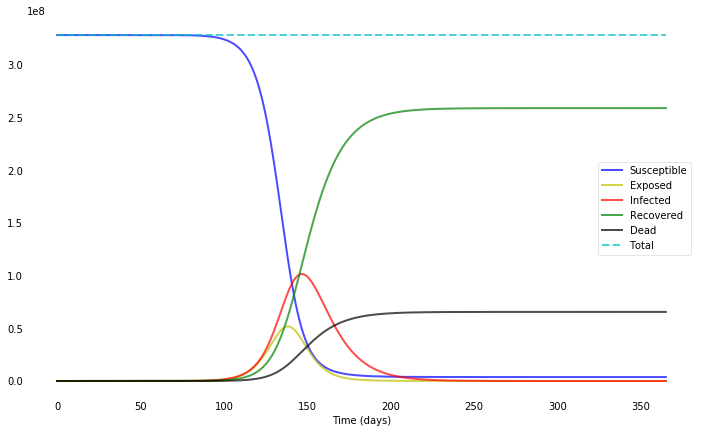

In [12]:
plotseird(t, S, E, I, R, D)

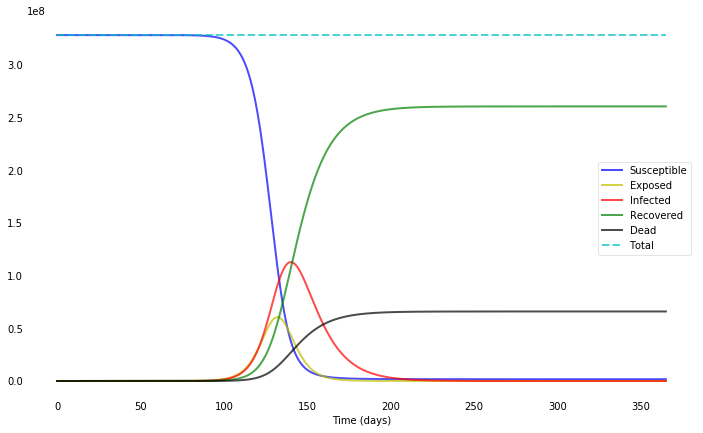

In [13]:
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv_original, y0, t, args=(N, 5.7 * gamma, gamma, delta, alpha, rho))
S_orig, E_orig, I_orig, R_orig, D_orig = ret.T
plotseird(t, S_orig, E_orig, I_orig, R_orig, D_orig)

In [14]:
def plotseird_both(t, S_orig, E_orig, I_orig, R_orig, D_orig, S, E, I, R, D):
    f, ax = plt.subplots(1,1,figsize=(12,7))
    ax.plot(t, S_orig, 'b', alpha=0.2, linewidth=1, label='Susceptible Original')
    ax.plot(t, E_orig, 'y', alpha=0.2, linewidth=1, label='Exposed Original')
    ax.plot(t, I_orig, 'r', alpha=0.2, linewidth=1, label='Infected Original')
    ax.plot(t, R_orig, 'g', alpha=0.2, linewidth=1, label='Recovered Original')
    ax.plot(t, D_orig, 'k', alpha=0.2, linewidth=1, label='Dead Original')
    ax.plot(t, S_orig+E_orig+I_orig+R_orig+D_orig, 'c--', alpha=0.2, linewidth=1, label='Total Original')
    
    ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
    ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')

    ax.set_xlabel('Time (days)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show();

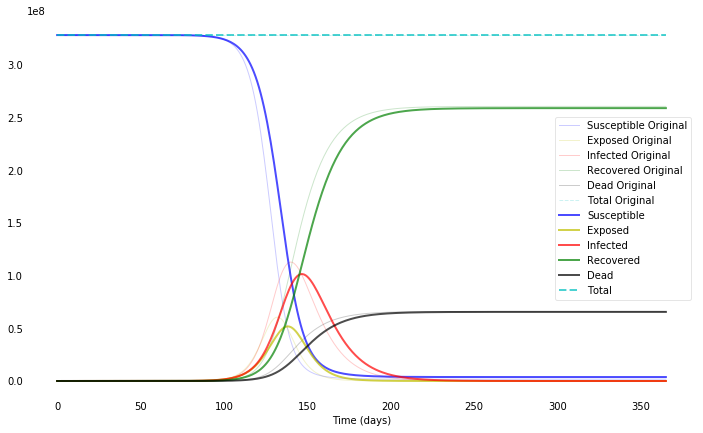

In [15]:
plotseird_both(t, S_orig, E_orig, I_orig, R_orig, D_orig, S, E, I, R, D)

In [16]:
def plotseird_both_subplots(t, S_orig, E_orig, I_orig, R_orig, D_orig, S, E, I, R, D):
    f, ax = plt.subplots(3,2,figsize=(20,17))
    ax[2, 0].plot(t, S_orig, 'b', alpha=0.2, linewidth=1, label='Susceptible Original')
    ax[2, 0].plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible New Model')
    ax[0, 0].plot(t, E_orig, 'y', alpha=0.2, linewidth=1, label='Exposed Original')
    ax[0, 0].plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed New Model')
    ax[0, 1].plot(t, I_orig, 'r', alpha=0.2, linewidth=1, label='Infected Original')
    ax[0, 1].plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected New Model')
    ax[1, 0].plot(t, R_orig, 'g', alpha=0.2, linewidth=1, label='Recovered Original')
    ax[1, 0].plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered New Model')
    ax[1, 1].plot(t, D_orig, 'k', alpha=0.2, linewidth=1, label='Dead Original')
    ax[1, 1].plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead New Model')

    ax[2, 1].plot(t, S_orig, 'b', alpha=0.2, linewidth=1, label='Susceptible Original')
    ax[2, 1].plot(t, E_orig, 'y', alpha=0.2, linewidth=1, label='Exposed Original')
    ax[2, 1].plot(t, I_orig, 'r', alpha=0.2, linewidth=1, label='Infected Original')
    ax[2, 1].plot(t, R_orig, 'g', alpha=0.2, linewidth=1, label='Recovered Original')
    ax[2, 1].plot(t, D_orig, 'k', alpha=0.2, linewidth=1, label='Dead Original')
    ax[2, 1].plot(t, S_orig+E_orig+I_orig+R_orig+D_orig, 'c--', alpha=0.2, linewidth=1, label='Total Original')
    
    ax[2, 1].plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible New Model')
    ax[2, 1].plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed New Model')
    ax[2, 1].plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected New Model')
    ax[2, 1].plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered New Model')
    ax[2, 1].plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead New Model')
    ax[2, 1].plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
    
    
    for a in ax:  
        for i in range(2):
            a[i].set_xlabel('Time (days)')
            a[i].yaxis.set_tick_params(length=0)
            a[i].xaxis.set_tick_params(length=0)
            a[i].grid(b=True, which='major', c='w', lw=2, ls='-')
            legend = a[i].legend()
            legend.get_frame().set_alpha(0.5)
            for spine in ('top', 'right', 'bottom', 'left'):
                a[i].spines[spine].set_visible(False)
    plt.show();

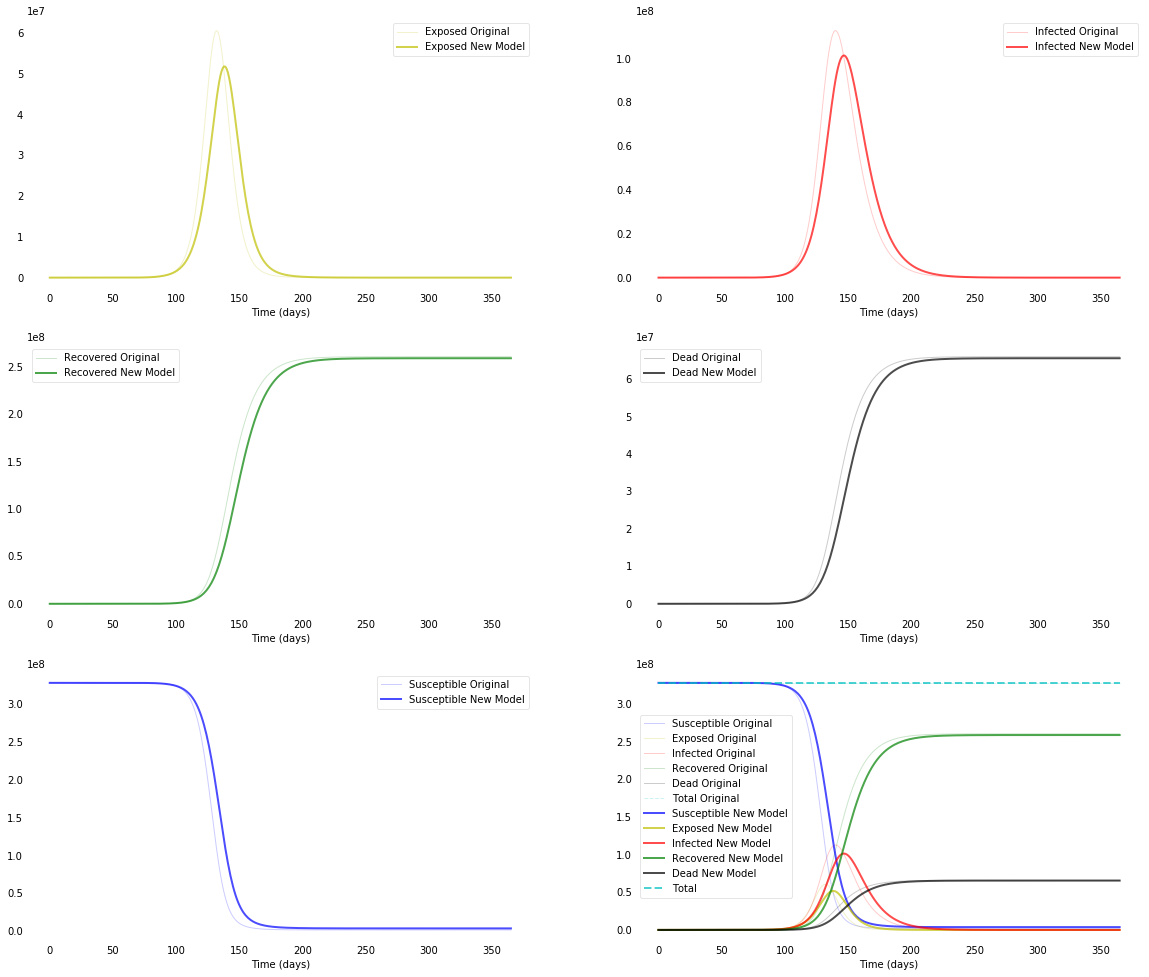

In [17]:
plotseird_both_subplots(t, S_orig, E_orig, I_orig, R_orig, D_orig, S, E, I, R, D)

# Mobility Time Series Forecasting

In [18]:
from fbprophet import Prophet

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

In [19]:
def get_country_mobility(country):
    return google_mobility.iloc[np.where(google_mobility.country_region == country)]

united_states_mobility = get_country_mobility('United States')
google_us_only = united_states_mobility.iloc[np.where(united_states_mobility.sub_region_1.astype('str') == 'nan')]
google_us_only = google_us_only.drop(columns=['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2'])

In [20]:
before_lockdown_mask = (google_us_only['date'] <= '2020-03-20')
lockdown_mask = (google_us_only['date'] > '2020-03-20')
us_before_lockdown = google_us_only.loc[before_lockdown_mask]
us_in_lockdown = google_us_only.loc[lockdown_mask]

before_spread_mask = (google_us_only['date'] <= '2020-03-12')
us_before_spread = google_us_only.loc[before_spread_mask]

In [21]:
mobility_columns = ['retail_and_recreation_percent_change_from_baseline',
                    'grocery_and_pharmacy_percent_change_from_baseline',
                    'parks_percent_change_from_baseline',
                    'transit_stations_percent_change_from_baseline',
                    'workplaces_percent_change_from_baseline',
                    'residential_percent_change_from_baseline']

In [22]:
def forecast_mobility(mobility_data, days):
    
    forecasts = []
    fig = plt.figure(figsize=(20,17))
    
    last_date = mobility_data.iloc[-1].date
    
    for i, col in enumerate(mobility_columns):
        google_col = mobility_data[['date', col]].rename(columns={'date':'ds', col:'y'})
        google_prophet = Prophet()
        google_prophet.fit(google_col)
        google_forecast = google_prophet.make_future_dataframe(periods=days, freq='D')
        google_forecast = google_prophet.predict(google_forecast)
        forecasts.append(google_forecast.yhat)
        google_prophet.plot(google_forecast, xlabel='Date', ylabel='mobility', ax=fig.add_subplot(3,2,i+1))
        plt.title(col)
        # google_prophet.plot_components(google_forecast) # this is for more info
        
    forecasts_df = pd.DataFrame(np.array(forecasts).T, columns=mobility_columns, index=google_prophet.make_future_dataframe(periods=days, freq='D').ds)
    forecasts_df = forecasts_df.reset_index().rename(columns={'ds':'date'})
    mask = (forecasts_df.date > last_date)
    forecasts_df = forecasts_df.loc[mask]

#     return mobility_data.append(forecasts_df, ignore_index=True)
    return forecasts_df

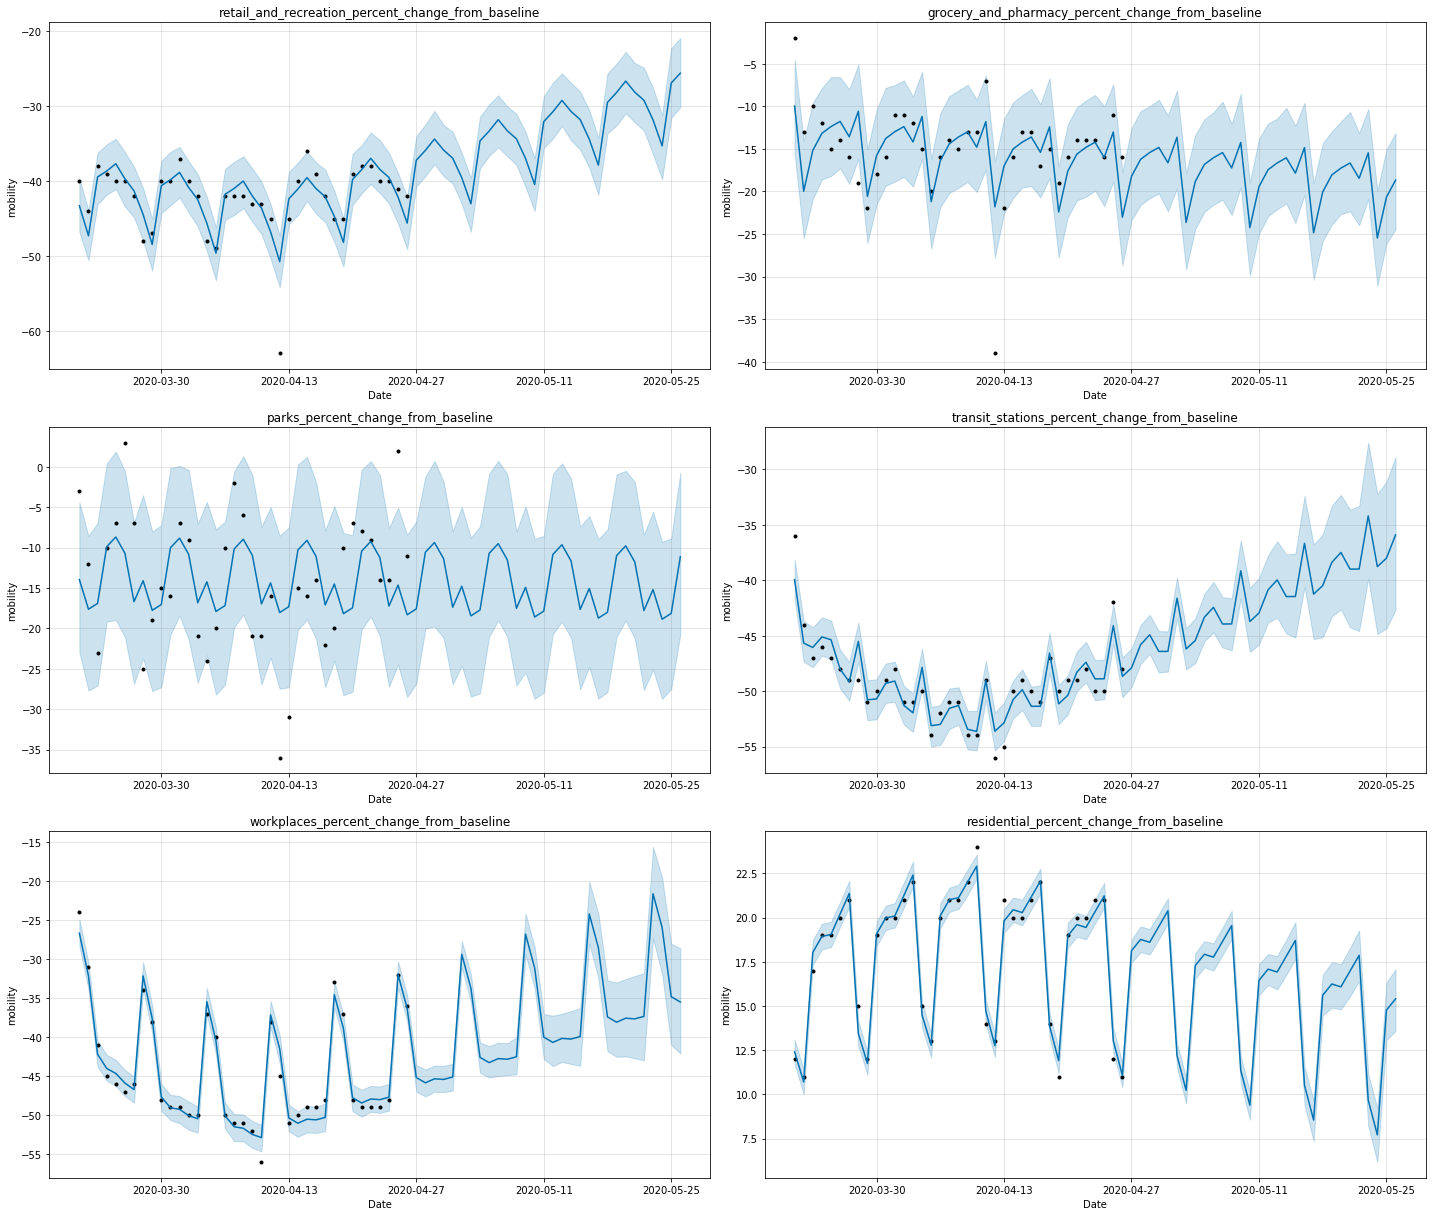

In [23]:
us_mobility_lockdown_forecast = google_us_only.append(forecast_mobility(us_in_lockdown, 30), ignore_index=True)
us_mobility_lockdown_forecast.to_csv('nick/us_mobility_lockdown_forecast.csv')

Text(0.5, 1.0, 'Forecast of Mobility in the US with Lockdown')

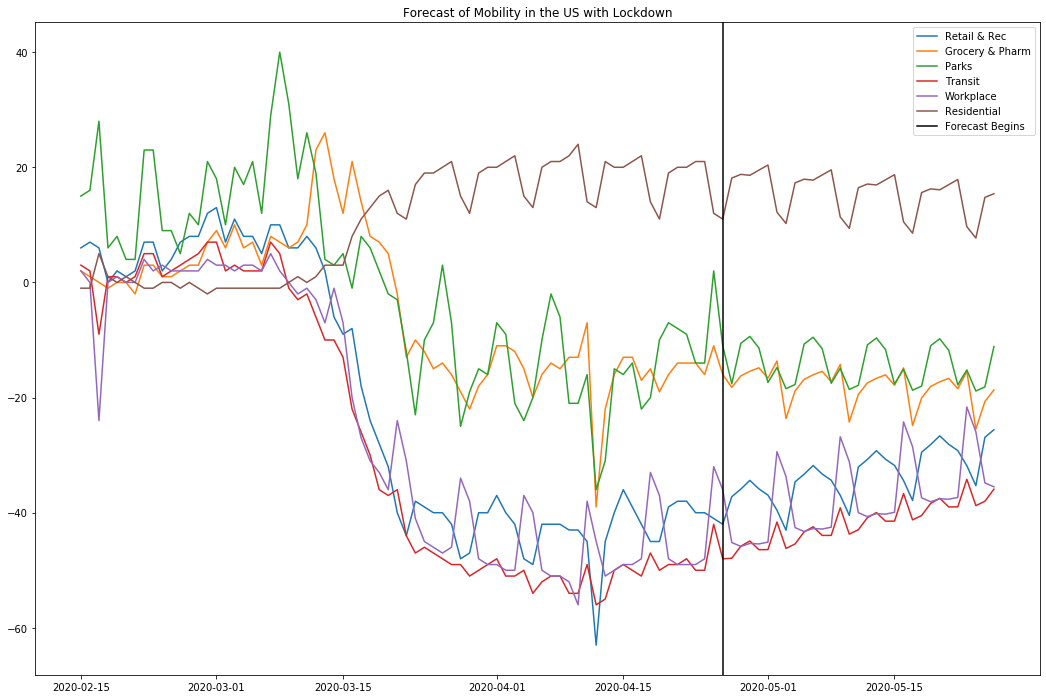

In [24]:
plt.figure(figsize=(18,12))
plt.plot(us_mobility_lockdown_forecast.date, us_mobility_lockdown_forecast.retail_and_recreation_percent_change_from_baseline, label='Retail & Rec')
plt.plot(us_mobility_lockdown_forecast.date, us_mobility_lockdown_forecast.grocery_and_pharmacy_percent_change_from_baseline, label='Grocery & Pharm')
plt.plot(us_mobility_lockdown_forecast.date, us_mobility_lockdown_forecast.parks_percent_change_from_baseline, label='Parks')
plt.plot(us_mobility_lockdown_forecast.date, us_mobility_lockdown_forecast.transit_stations_percent_change_from_baseline, label='Transit')
plt.plot(us_mobility_lockdown_forecast.date, us_mobility_lockdown_forecast.workplaces_percent_change_from_baseline, label='Workplace')
plt.plot(us_mobility_lockdown_forecast.date, us_mobility_lockdown_forecast.residential_percent_change_from_baseline, label='Residential')
plt.axvline(x=google_us_only.iloc[-1].date, c='black', label='Forecast Begins')
plt.legend()
plt.title('Forecast of Mobility in the US with Lockdown')

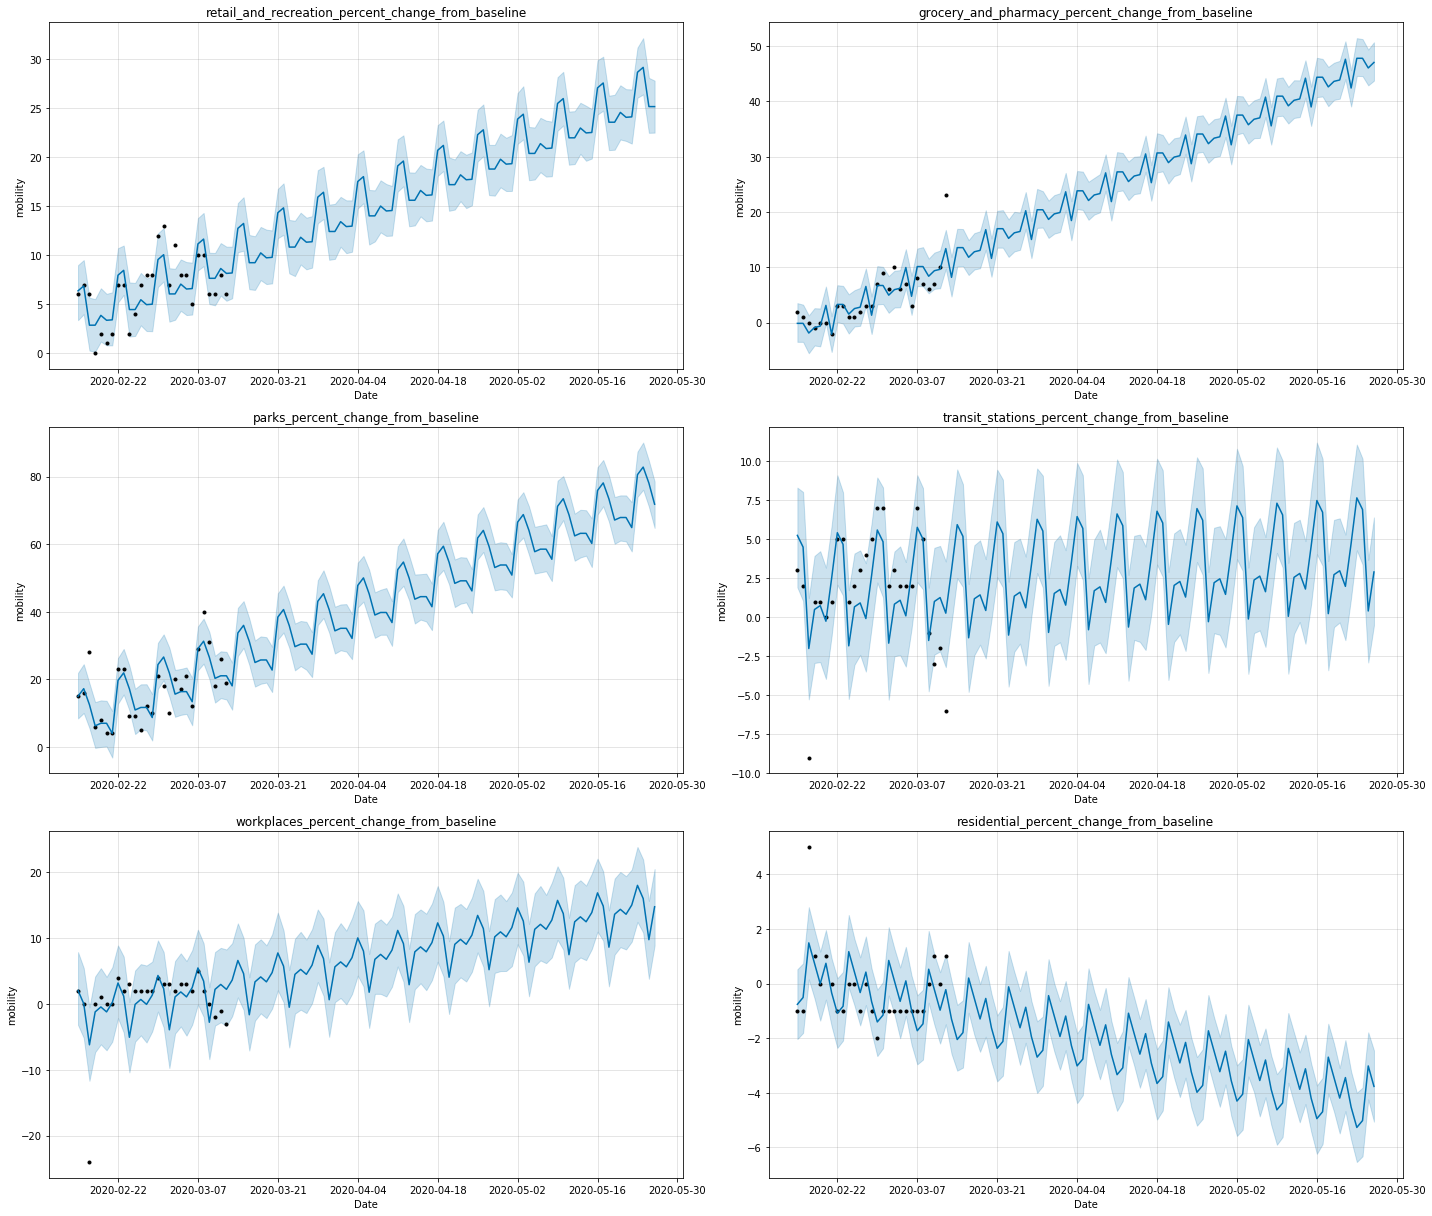

In [25]:
us_mobility_no_lockdown_forecast = us_before_spread.append(forecast_mobility(us_before_spread, 75), ignore_index=True)
us_mobility_no_lockdown_forecast.to_csv('nick/us_mobility_no_lockdown_forecast.csv')

Text(0.5, 1.0, 'Forecast of Mobility in the US with No Lockdown')

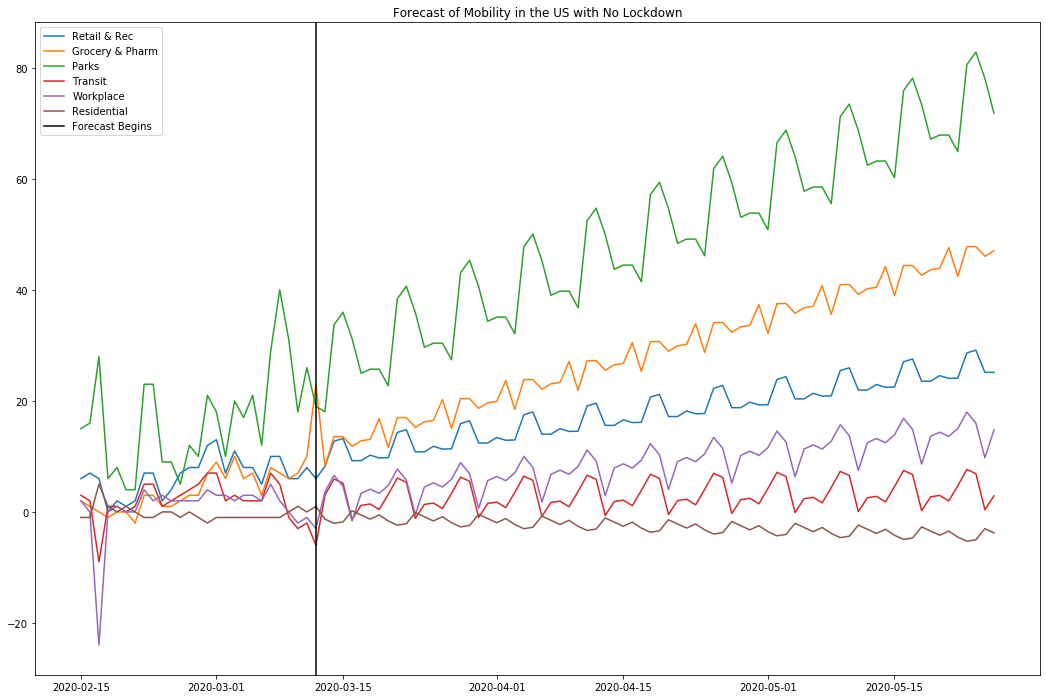

In [26]:
plt.figure(figsize=(18,12))
plt.plot(us_mobility_no_lockdown_forecast.date, us_mobility_no_lockdown_forecast.retail_and_recreation_percent_change_from_baseline, label='Retail & Rec')
plt.plot(us_mobility_no_lockdown_forecast.date, us_mobility_no_lockdown_forecast.grocery_and_pharmacy_percent_change_from_baseline, label='Grocery & Pharm')
plt.plot(us_mobility_no_lockdown_forecast.date, us_mobility_no_lockdown_forecast.parks_percent_change_from_baseline, label='Parks')
plt.plot(us_mobility_no_lockdown_forecast.date, us_mobility_no_lockdown_forecast.transit_stations_percent_change_from_baseline, label='Transit')
plt.plot(us_mobility_no_lockdown_forecast.date, us_mobility_no_lockdown_forecast.workplaces_percent_change_from_baseline, label='Workplace')
plt.plot(us_mobility_no_lockdown_forecast.date, us_mobility_no_lockdown_forecast.residential_percent_change_from_baseline, label='Residential')
plt.axvline(x=us_before_spread.iloc[-1].date, c='black', label='Forecast Begins')
plt.legend()
plt.title('Forecast of Mobility in the US with No Lockdown')